In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

In [16]:
print(tf.test.gpu_device_name())

/device:GPU:0


The `Sampling` layer below uses a standard normal RV in order to sample $z$ as follows:
\begin{align}
  z_i &\sim N(\mu_i, \sigma^2_i) \\
  \implies z_i &= \mu_i + \sigma_i \epsilon_i \ , \ \ \text{where} \ \epsilon_i \sim N(0,1)
\end{align}

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [18]:
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=2, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [19]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

In [22]:
class VAE(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=2,
        name="autoencoder",
        **kwargs
    ):
        super(VAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Add KL divergence regularization loss.
        reconstruction_loss = keras.losses.binary_crossentropy(inputs, reconstructed)
        reconstruction_loss = self.original_dim * K.mean(reconstruction_loss)
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss = -0.5 * K.mean(kl_loss)
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_loss(reconstruction_loss)
        self.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

        return reconstructed


In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

vae = VAE(
    original_dim=784,
    intermediate_dim=64,
    latent_dim=2
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer='adam')

hist = vae.fit(
    x_train, x_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(x_test, x_test)
)

Epoch 1/20
938/938 [==============================] - 5s 4ms/step - loss: 300.8542 - kl_loss: 3.7801 - mse_loss: 297.0741 - val_loss: 206.9205 - val_kl_loss: 0.1508 - val_mse_loss: 206.7697
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 206.9441 - kl_loss: 0.1044 - mse_loss: 206.8398 - val_loss: 206.2081 - val_kl_loss: 0.0279 - val_mse_loss: 206.1802
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 206.4225 - kl_loss: 0.0260 - mse_loss: 206.3964 - val_loss: 205.9781 - val_kl_loss: 0.0083 - val_mse_loss: 205.9698
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 206.2391 - kl_loss: 0.0083 - mse_loss: 206.2309 - val_loss: 206.0640 - val_kl_loss: 0.0046 - val_mse_loss: 206.0595
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 206.3865 - kl_loss: 0.0023 - mse_loss: 206.3842 - val_loss: 205.9802 - val_kl_loss: 0.0024 - val_mse_loss: 205.9777
Epoch 6/20
938/938 [==============================

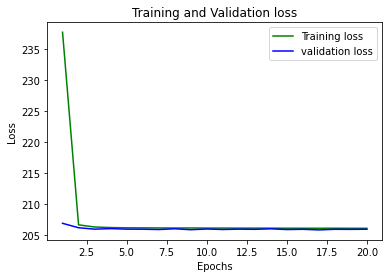

In [25]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1, 20+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

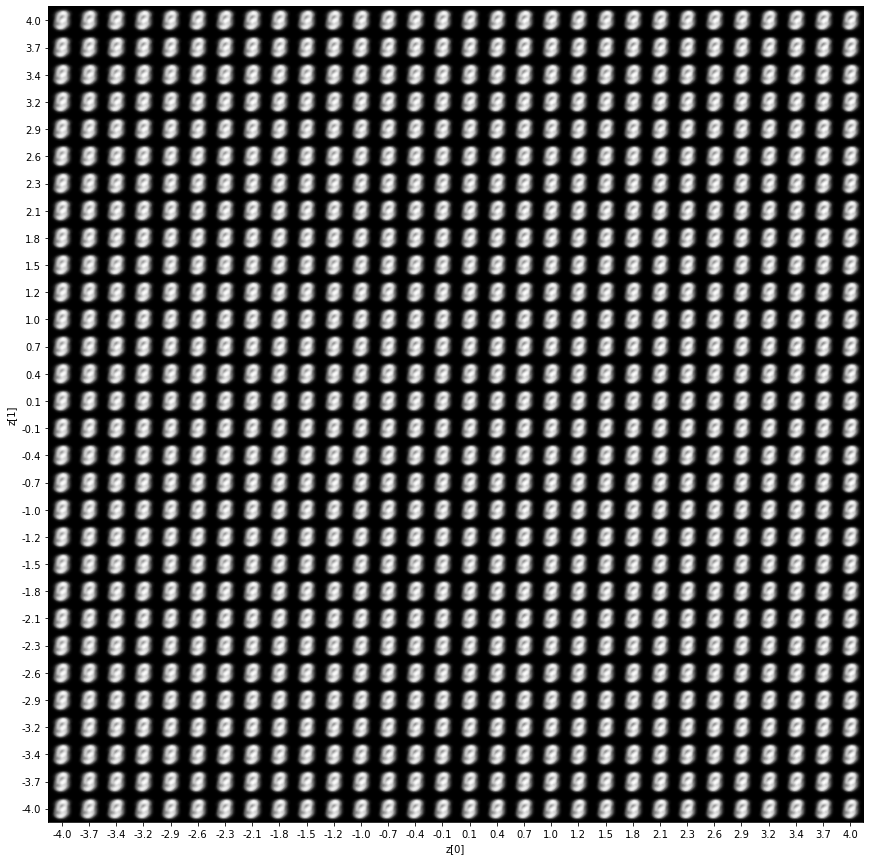

In [26]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 4.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder(z_sample)
            x_decoded = x_decoded.numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

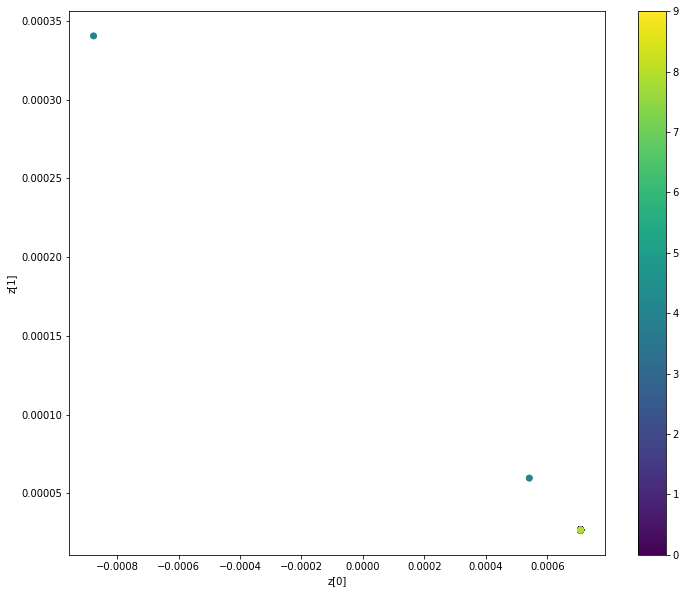

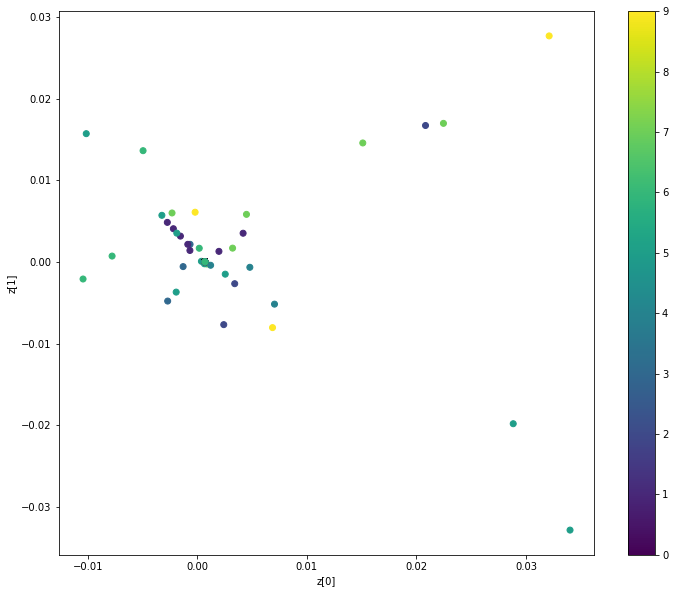

In [27]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)
plot_label_clusters(vae, x_test, y_test)

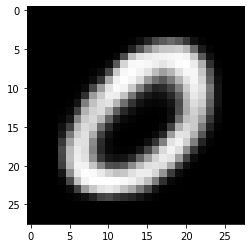

In [14]:
digit_size = 28

z_sample = np.array([[1, 3]])
x_decoded = vae.decoder(z_sample)
x_decoded = x_decoded.numpy()
digit = x_decoded[0].reshape(digit_size, digit_size)
plt.imshow(digit, cmap='gray')
